In [1]:
# Python Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib import rcParams
%matplotlib inline

style.use('seaborn-poster')
style.use('ggplot')
plt.rcParams['font.size'] = 12
plt.rcParams['font.weight'] = 'bold'


# Snowflake Import

from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL

url = URL (
    account = 'tq01613.us-east-1',
    user = 'ron.nahshon@lemonade.com',
    password = 'R0n1@lemonade',
    database = 'lemonade',
    schema = 'public',
    warehouse = 'compute_wh',
    role='analyst',
)

engine = create_engine(url)
connection = engine.connect()

# Correlation Between Bought Policies and Prepaid Attempts

In [2]:
query = """        

SELECT
r.score,
COUNT(DISTINCT i.user_id) AS num_users_with_prepaid_attempts,
COUNT(DISTINCT p.user_id) AS num_users_with_policies,
ROUND(100.0 * num_users_with_prepaid_attempts / num_users_with_policies, 2) AS pct_users_with_prepaid_attempt,
ROUND(1.0 * COUNT(i.id) / num_users_with_prepaid_attempts, 2) AS num_attempts_per_user
    FROM risk_scores AS r
        JOIN quotes AS q
        ON r.entity_id = q.id
        JOIN policies AS p
        ON p.quote_id = q.id
        LEFT JOIN risk_indicators AS i
        ON (i.user_id = p.user_id
        AND i.indicator = 'prepaid_card_attempt')
            WHERE r.entity_type = 'quote'
            AND q.form = 'ho4'
    GROUP BY 1
    ORDER BY 1;

"""

df = pd.read_sql(query, connection)
print('Dataframe Shape', df.shape)
df.head()

Dataframe Shape (10, 5)


,score,num_users_with_prepaid_attempts,num_users_with_policies,pct_users_with_prepaid_attempt,num_attempts_per_user
0,1,37,3621,1.02,5.73
1,2,39,4026,0.97,2.79
2,3,85,5080,1.67,6.88
3,4,195,6633,2.94,6.10
4,5,368,7614,4.83,5.27


In [3]:
profile = pandas_profiling.ProfileReport(df)
profile.to_file(outputfile="output.html")

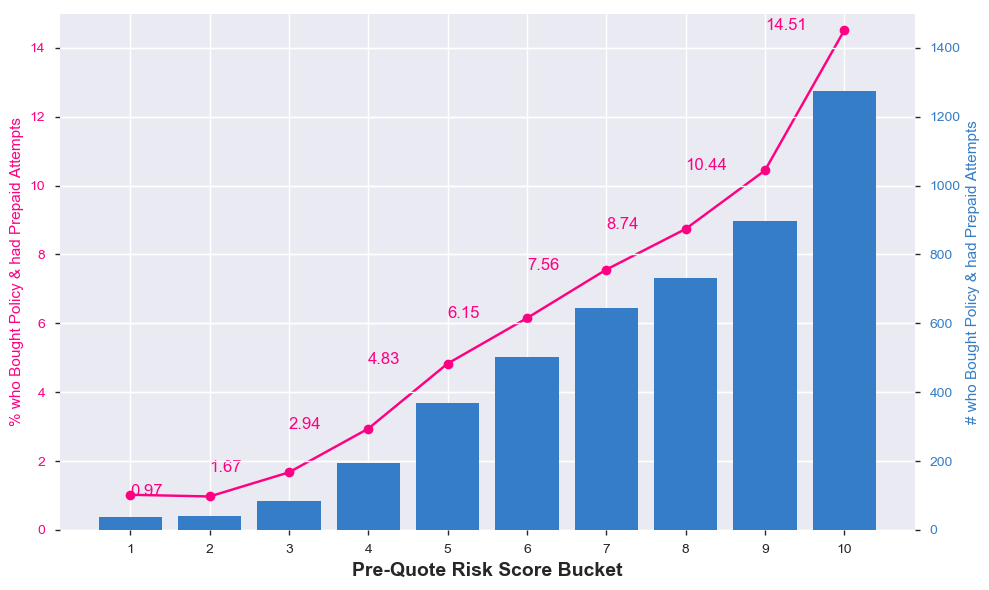

In [4]:
# Visualize Correlation

from matplotlib.ticker import FormatStrFormatter

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1_vals = [0, 14/7, 14/7*2, 14/7*3, 14/7*4, 14/7*5, 14/7*6, 14]
ax2_vals = [0, 1400/7, 1400/7*2, 1400/7*3, 1400/7*4, 1400/7*5, 1400/7*6, 1400]
ax1.plot(df['score'], df['pct_users_with_prepaid_attempt'], color='#ff0083', marker='o')
ax2.bar(df['score'], df['num_users_with_prepaid_attempts'], color='#357EC7')
ax1.set_xlabel('Pre-Quote Risk Score Bucket', fontweight='bold', fontsize=14)
ax1.set_ylabel('% who Bought Policy & had Prepaid Attempts', color='#ff0083')
ax2.set_ylabel('# who Bought Policy & had Prepaid Attempts', color='#357EC7')
ax1.set_ylim(0,15)
ax2.set_ylim(0,1500)
ax1.yaxis.label.set_color('#ff0083')
ax2.yaxis.label.set_color('#357EC7')
ax1.set_yticklabels(labels=ax1_vals, color='#ff0083')
ax2.set_yticklabels(labels=ax2_vals, color='#357EC7')
ax1.set_xticks([1,2,3,4,5,6,7,8,9,10])
for i,j in df['pct_users_with_prepaid_attempt'].items():
    ax1.annotate(str(j), xy=(i, j), color='#ff0083', fontsize=12)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
# plt.title("HRUs are More Likely to Have Prepaid Card Attempt", fontsize=18, fontweight='bold')

plt.tight_layout()
plt.savefig("Prepaid Card Attempts by Pre-Quote Bucket Scores.png", bbox_inches='tight');

---

# Correlation Between Claims and Prepaid Attempts

In [15]:
query2 = """        

WITH a AS
(
SELECT
r.score,
p.user_id,
CASE WHEN i.user_id IS NOT NULL THEN i.user_id ELSE NULL END AS had_attempt
  FROM risk_scores AS r
      JOIN quotes AS q
      ON r.entity_id = q.id
      JOIN policies AS p
      ON p.quote_id = q.id
      JOIN claims AS c
      ON (c.policy_id = p.id
      AND (c.auto_declined = 1
      OR (c.settled = 1 AND c.paid = 0)))
      LEFT JOIN risk_indicators AS i
      ON (i.user_id = p.user_id
      AND i.indicator = 'prepaid_card_attempt')
          WHERE r.entity_type = 'quote'
          AND q.form = 'ho4'
),

b AS
(
SELECT score,
COUNT(DISTINCT CASE WHEN user_id IS NOT NULL THEN user_id ELSE NULL END) AS had_claim,
COUNT(DISTINCT CASE WHEN had_attempt IS NOT NULL THEN user_id ELSE NULL END) AS had_pp_attempt
-- SUM(CASE WHEN user_id IS NOT NULL THEN 1 ELSE 0 END) AS had_claim,
-- SUM(CASE WHEN had_attempt IS NOT NULL THEN 1 ELSE 0 END) AS had_pp_attempt
    FROM a
    GROUP BY 1
),

c AS
(
SELECT score, COUNT(DISTINCT p.user_id) AS num_users
      FROM risk_scores AS r
          JOIN quotes AS q
          ON r.entity_id = q.id
          JOIN policies AS p
          ON p.quote_id = q.id
      GROUP BY 1
)

SELECT
b.score, c.num_users, b.had_claim, b.had_pp_attempt, 
ROUND(100.0 * had_claim / num_users, 2) AS pct_users_had_claim, 
ROUND(100.0 * had_pp_attempt / num_users, 2) AS pct_users_had_pp_attempt,
ROUND(100.0 * had_pp_attempt / had_claim, 2) AS pct_had_claim_that_had_pp_attempt
    FROM b
    LEFT JOIN c
    ON b.score = c.score 
    ORDER BY 1;

"""

df2 = pd.read_sql(query2, connection)
print('Dataframe Shape', df2.shape)
df2

Dataframe Shape (10, 7)


,score,num_users,had_claim,had_pp_attempt,pct_users_had_claim,pct_users_had_pp_attempt,pct_had_claim_that_had_pp_attempt
0,1,3725,4,0,0.11,0.00,0.00
1,2,4221,9,0,0.21,0.00,0.00
2,3,5264,13,0,0.25,0.00,0.00
3,4,6912,8,1,0.12,0.01,12.50
4,5,7941,15,2,0.19,0.03,13.33
5,6,8459,16,2,0.19,0.02,12.50
6,7,8796,16,3,0.18,0.03,18.75
7,8,8661,23,9,0.27,0.10,39.13
8,9,8837,19,6,0.22,0.07,31.58
9,10,9079,31,10,0.34,0.11,32.26


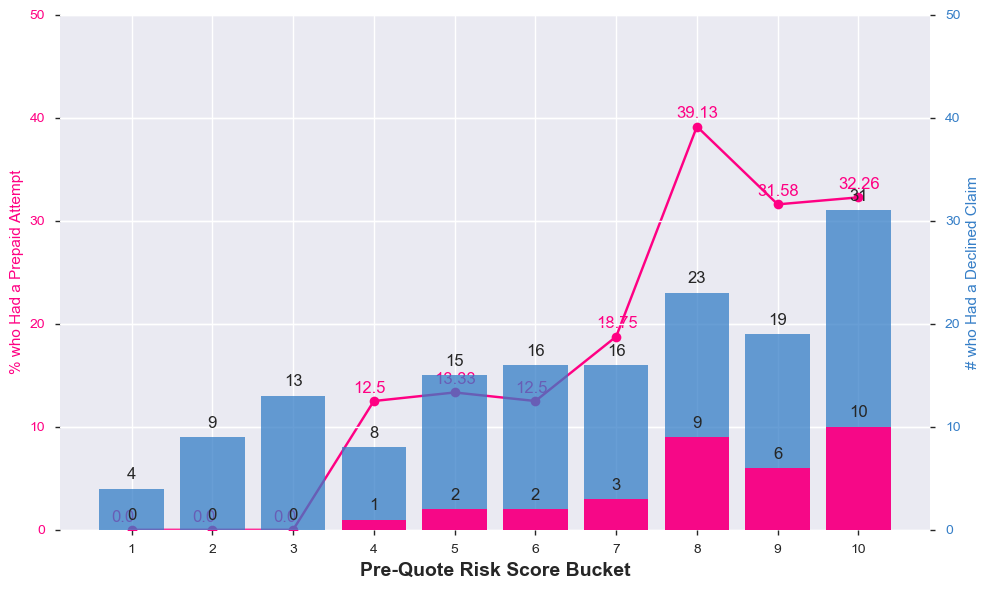

In [46]:
# Visualize Correlation

from matplotlib.ticker import FormatStrFormatter

fig, ax1 = plt.subplots(figsize=(10,6))
ax2 = ax1.twinx()
ax1_vals = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ax2_vals = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
ax1.plot(df2['score'], df2['pct_had_claim_that_had_pp_attempt'], color='#ff0083', marker='o', alpha=1)
ax2.bar(df2['score'], df2['had_claim'], color='#357EC7', alpha=0.75)
ax2.bar(df2['score'], df2['had_pp_attempt'], color='#ff0083', alpha=0.95)
ax1.set_xlabel('Pre-Quote Risk Score Bucket', fontweight='bold', fontsize=14)
ax1.set_ylabel('% who Had a Prepaid Attempt', color='#ff0083')
ax2.set_ylabel('# who Had a Declined Claim', color='#357EC7')
ax1.set_ylim(0,50)
ax2.set_ylim(0,50)
ax1.yaxis.label.set_color('#ff0083')
ax2.yaxis.label.set_color('#357EC7')
ax1.set_yticklabels(labels=ax1_vals, color='#ff0083')
ax2.set_yticklabels(labels=ax2_vals, color='#357EC7')
ax1.set_xticks([1,2,3,4,5,6,7,8,9,10])

for i,j in df2['pct_had_claim_that_had_pp_attempt'].items():
    ax1.annotate(str(j), xy=(i+0.75, j+0.5), color='#ff0083', fontsize=12, ha='left', va='bottom')
    
for p in ax2.patches:
    ax2.annotate(np.round(p.get_height(), decimals=0), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), 
                textcoords='offset points', fontsize=12)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.f'))

plt.tight_layout()
plt.savefig("Prepaid Card Attempts from Users who Submitted Declined Claims by Bucket.png", bbox_inches='tight');

---